# Deep Research

In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, List, Optional, Annotated
from langchain_core.messages import BaseMessage,HumanMessage, AIMessage
from langgraph.graph import START, END, StateGraph, add_messages
from pydantic import BaseModel, Field
from uuid import uuid4
from datetime import datetime


load_dotenv()


True

### (deprecated) Define state and schema of blackboard (shared among agents)

In [ ]:
from enum import Enum
from pydantic import BaseModel, Field, HttpUrl
from datetime import datetime, timezone

class FactKind(str, Enum):
    finding = "finding"
    draft = "draft"
    critique = "critique"
    plan_step = "plan_step"
    scholar_reference = "scholar_reference"        # formal academic item
    general_reference = "general_reference"      # blog/vendor docs/etc.
    note = "note"

class Citation(BaseModel):
    title: Optional[str] = Field(None, description="Publication title.")
    url: Optional[HttpUrl] = Field(None, description="Canonical/stable link.")
    authors: Optional[List[str]] = Field(None, description="Author list.")
    venue: Optional[str] = Field(None, description="Journal/conference or 'arXiv'.")
    year: Optional[int] = Field(None, ge=1900, le=2100, description="Publication year.")
    doi: Optional[str] = Field(None, description="DOI if available.")
    arxiv_id: Optional[str] = Field(None, description="arXiv ID like 2405.06211. Leave null if unknown.")
    snippet: Optional[str] = None
    contributions: Optional[List[str]] = Field(
        None, description="2–5 bullets of concrete contributions/novelty, if any."
    )

    results: Optional[List[str]] = Field(
        None, description="1–4 concrete metrics/ original claims, if applicable.",
        min_length=1,max_length=4
    )

    extended_summary: str = Field(
        None,
        description="~50–300 words giving an accurate and detailed overview of the article findings"
        )
    
    tags: Optional[List[str]] = Field(None, description="Short tags.")   


class Reference(BaseModel):
    title: str = Field(..., description="Title of blog/doc/tutorial/case study.")
    url: HttpUrl = Field(..., description="Link to the source.")
    publisher: Optional[str] = Field(None, description="Blog/company site.")
    author: Optional[str] = Field(None, description="Main author if available.")
    year: Optional[int] = Field(None, description="Year.")
    snippet: Optional[str] = Field(None, description="50–300 words accurately summarizing the 'source' findings, and their relevance to the research question.")


#maybe this only for elaborating the stuff i found and synthesize insight
class Finding(BaseModel):
    statement: str = Field(description="1–2 sentence synthesized insight.")                              # 1–2 sentences
    supporting_sources: Optional[List[HttpUrl]] = Field(
        None, description="sources backing this finding."
    )


class Fact(BaseModel):
    # id/created_at are best filled server-side; keep them optional in schema
    id: Optional[str] = Field(None, description="Server-generated unique identifier.")
    kind: FactKind
    #content: str
    created_at: Optional[datetime] = Field(
        None, description="Server timestamp; use datetime.now(timezone.utc)."
    )
    #this probably best to be handled in "reducer" for the blackboard
    #replaces: Optional[str] = Field(None, description="ID of a superseded fact.")
    scholar_references: Optional[List[Citation]] = Field(
        None,
        description="Formal bibliographic references (peer-reviewed papers, preprints,reports).")
    
    general_references: Optional[List[Reference]] = Field(
        None, description="Informal web sources (blogs, docs, tutorials)."
    )

    confidence: Optional[float] = Field(
        None, ge=0.0, le=1.0, description="Self-estimated confidence of relevance to research question 0–1"
    )

class ResearchOutput(BaseModel):
    topic: str
    facts: List[Fact]

    
# State definition
class ResearchState(TypedDict):
    topic: str
    blackboard: List[Fact]
    researcher_msgs: Annotated[list[BaseMessage],add_messages]
    writer_msgs: Annotated[list[BaseMessage],add_messages]


# === Test Schema ===
sample_fact = Fact(
    kind="finding",
    content="LangGraph allows for building cyclical agentic workflows.",
    source_agent="Researcher"
)

# Pydantic models have a nice `model_dump_json` method for inspection
print(sample_fact.model_dump_json(indent=2))



NameError: name 'Optional' is not defined

### New approach
IDEA:
1) Planner -> plan
2) Researcher -> gather resources and write to blackboard
3) Synthesizer -> read one by one the blackboard and fill more detailed fields, also synthesize Findings

In [16]:
from typing import Union
from typing import Optional, List, TypedDict
from pydantic import BaseModel, HttpUrl, Field
from enum import Enum
import operator
from langgraph.prebuilt.chat_agent_executor import AgentState

class FactKind(str, Enum):
    finding = "finding"
    draft = "draft"
    critique = "critique"
    plan_step = "plan_step"
    scholar_reference = "scholar_reference"        # formal academic item
    general_reference = "general_reference"      # blog/vendor docs/etc.
    note = "note"

        
class Citation(BaseModel):
    # --- Fields for the COLLECTOR agent (easy to find) ---
    title: Optional[str] = Field(None, description="Publication title.")
    url: Optional[HttpUrl] = Field(None, description="Canonical/stable link.")
    authors: Optional[List[str]] = Field(None, description="Author list.")
    venue: Optional[str] = Field(None, description="Journal/conference or 'arXiv'.")
    year: Optional[int] = Field(None, description="Publication year.")
    doi: Optional[str] = Field(None, description="DOI if available.")
    arxiv_id: Optional[str] = Field(None, description="arXiv ID like 2405.06211.")

    # --- Fields for the ENRICHMENT agent (require analysis) ---
    snippet: Optional[str] = Field(
        None, description="A brief, quoted sentence or two from the source."
    )
    contributions: Optional[List[str]] = Field(
        None, description="[ENRICHMENT] 2–5 bullets of concrete contributions/novelty."
    )
    results: Optional[List[str]] = Field(
        None, description="[ENRICHMENT] 1–4 concrete metrics or original claims."
    )
    extended_summary: Optional[str] = Field(
        None,
        description="[ENRICHMENT] ~50–300 words giving an accurate overview."
    )
    tags: Optional[List[str]] = Field(None, description="Short tags.")


class Reference(BaseModel):
    # --- Fields for the COLLECTOR agent ---
    title: str = Field(..., description="Title of blog/doc/tutorial/case study.")
    url: HttpUrl = Field(..., description="Link to the source.")
    publisher: Optional[str] = Field(None, description="Blog/company site.")
    author: Optional[str] = Field(None, description="Main author if available.")
    year: Optional[int] = Field(None, description="Year.")

    # --- Field for the ENRICHMENT agent ---
    snippet: Optional[str] = Field(
        None, 
        description="[ENRICHMENT] 50–300 words accurately summarizing the source's findings."
    )


class Finding(BaseModel):
    statement: str = Field(description="1–2 sentence synthesized insight.")                              # 1–2 sentences
    supporting_sources: Optional[List[HttpUrl]] = Field(
        None, description="sources backing this finding."
    )


class Fact(BaseModel):
    id: Optional[str] = Field(None, description="Server-generated unique identifier.")
    kind: FactKind
    content: Union[Citation, Reference, Finding, str] # Use a Union for content
    created_at: Optional[datetime] = Field(
        None, description="Server timestamp."
    )
    confidence: Optional[float] = Field(
        None, ge=0.0, le=1.0, description="Self-estimated confidence of relevance 0–1."
    )


class Step(BaseModel):
    """A single, atomic step in a research plan."""
    task: str = Field(..., description="The specific, imperative task for the researcher to perform.")
    expected_output: str = Field(..., description="A description of the expected output from this step.")

class Plan(BaseModel):
    """A structured research plan."""
    main_query: str = Field(..., description="A single crisp query to kick off search, summarizing the topic.")
    steps: List[Step] = Field(..., description="The list of atomic, ordered steps to execute.")
    success_criteria: List[str] = Field(..., description="A checklist of criteria to verify the research is complete.")


class ResearchState(AgentState): #TypedDict AgentState
    """The live blackboard that is passed between agents."""
    topic: str
    facts: Annotated[list[Fact], operator.add]
    plan: Plan 

class ResearchOutput(BaseModel):
    """The final, clean output of the entire research process."""
    topic: str
    facts: List[Fact]



In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class MyState(TypedDict):
    x: int

def my_node(state: MyState):
    # returning a key not in MyState, it gets ignored
    return {"x": state["x"] + 1, "y": 5}

builder = StateGraph(MyState)
builder.add_node("bad_node", my_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", END)

graph = builder.compile()

# This is where you'll see the error:
out = graph.invoke({"x": 1})
print(out)
out2 = graph.invoke({"x": 3})
print(out2)


{'x': 2}
{'x': 4}


### Tools 

#### Search Tools
STRATEGY:
- an agent for each type of search (arxiv, web, wikipedia)
- a supervisor researcher agent that manages those
- a record_fact tool to push to the blackboard 

In [17]:
from typing import TypedDict, List, Optional
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_core.tools import StructuredTool
from pydantic import BaseModel, Field
import json
import uuid


tavily_tool = TavilySearchResults(max_results=5)

class ArxivSearchInput(BaseModel):
    query: str = Field(description="The search query for scientific papers on ArXiv.")

def arxiv_search_fn(query: str, config: RunnableConfig) -> str:
    cfg = (config or {}).get("configurable", {})
    top_k = int(cfg.get("arxiv_top_k", 3))
    wrapper = ArxivAPIWrapper(top_k_results=top_k)
    return wrapper.run(query)

arxiv_tool = StructuredTool.from_function(
    name="arxiv_search",
    description="Search ArXiv for scientific papers.",
    args_schema=ArxivSearchInput,
    func=arxiv_search_fn,
    handle_tool_error=True
)

# EXPERIMENTAL WRAPPING TO GET ELABORATE ERROR HANDLING BEHAVIOR

class WikipediaSearchInput(BaseModel):
    query: str = Field(description="The search query for general knowledge on Wikipedia.")

def wikipedia_search_fn(query:str , config: RunnableConfig):

    cfg = (config or {}).get("configurable", {})
    top_k: int = int(cfg.get("wikipedia_top_k", 3))
    lang = cfg.get("wikipedia_lang", "en")
    wrapper = WikipediaAPIWrapper(top_k_results=top_k, lang=lang)
    return wrapper.run(query)

runnable_wiki_search = RunnableLambda(wikipedia_search_fn).with_retry(wait_exponential_jitter=True,stop_after_attempt=3)

def wikipedia_tool_fn(query:str , config: RunnableConfig):

    return runnable_wiki_search.invoke(query, config=config)

wikipedia_tool = StructuredTool.from_function(
    func=wikipedia_tool_fn,
    name="wikipedia_search",
    description="Search Wikipedia for general knowledge.",
    args_schema=WikipediaSearchInput,
    handle_tool_error=True
)

research_tools = [tavily_tool, arxiv_tool, wikipedia_tool]

#### Add reference tools

In [ ]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command
from langgraph.prebuilt import InjectedState


# --- New Tool Functions ---
@tool
def add_scholar_reference_tool(
    citation: Citation,
#    state: Annotated[ResearchState, InjectedState] = None,  # injected by LangGraph, only need it if i want to inspect state
 #   tool_call_id: Annotated[str, InjectedToolCallId] = None,      # optional: for threading            
    ) -> Command:
    """
    Adds a formal academic citation (paper, preprint, etc.) to the research blackboard.
    Call this immediately after finding a relevant scholarly article.
    """
    fact = Fact(kind=FactKind.scholar_reference, content=citation)

    # Update the graph state; reducer will append to `blackboard`
    return Command(update={"facts": [fact]})




@tool
def add_general_reference_tool(
    reference: Reference,
    #state: Annotated[ResearchState, InjectedState] = None,  # injected by LangGraph, only need it if i want to inspect state
    tool_call_id: Annotated[str, InjectedToolCallId] = None,      # optional: for threading    
    ) -> Command:
    """
    Adds an informal web source (blog, docs, tutorial, wikipedia...) to the research blackboard.
    Call this immediately after finding a relevant blog post, documentation, or similar article.
    """
    fact = Fact(kind=FactKind.general_reference, content=reference)
    return Command(update={"facts": [fact]})


@tool 
def request_stop(reason: str = "") -> Command:
    "Call when the task is complete or no further progress is likely."
    # you can also append a final message/summary if you like
    return Command(update={"done": True})


#override transfer calls
@tool
def transfer_to_web_agent_tool(task: str = "") -> Command:
    "Call to transfer control to the web_agent"
    # Reset per-worker ReAct budget on entry
    return Command(
        update={"remaining_steps": 5, "current_task": task},
        goto="web_agent",           # jump into the worker graph
        graph=Command.PARENT
    )

@tool
def transfer_to_arxiv_agent_tool(task: str = "") -> Command:
    "Call to transfer control to the arxiv_agent"
    # Reset per-worker ReAct budget on entry
    return Command(
        update={"remaining_steps": 5, "current_task": task},
        goto="arxiv_agent",           # jump into the worker graph
        graph=Command.PARENT
    )


@tool
def transfer_to_wikipedia_agent_tool(task: str = "") -> Command:
    "Call to transfer control to the wikipedia_agent"
    # Reset per-worker ReAct budget on entry
    return Command(
        update={"remaining_steps": 5, "current_task": task},
        goto="wikipedia_agent",           # jump into the worker graph
        graph=Command.PARENT
    )
print("Tools defined successfully.")

Tools defined successfully.


### Create Planner Chain and react Agent
- only the roles that actually use tool require a react agent, the rest can be chains

In [5]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_openai import ChatOpenAI

# Planner chain

# class Step(BaseModel):
#     """A single, atomic step in a research plan."""
#     task: str = Field(..., description="The specific, imperative task for the researcher to perform.")
#     expected_output: str = Field(..., description="A description of the expected output from this step.")

# class Plan(BaseModel):
#     """A structured research plan."""
#     main_query: str = Field(..., description="A single crisp query to kick off search, summarizing the topic.")
#     steps: List[Step] = Field(..., description="The list of atomic, ordered steps to execute.")
#     success_criteria: List[str] = Field(..., description="A checklist of criteria to verify the research is complete.")


planner_prompt = ChatPromptTemplate.from_template(
"""You are a Research Planner. Your job is to take a broad research goal and turn it into a clear, step-by-step research plan.

You do not execute the research yourself — instead, you design a sequence of tasks that other specialized researcher agents will carry out.

---

Guidelines:
1. **Understand the Goal**: Restate the user’s task in your own words to ensure clarity.  
2. **Break Down the Problem**: Identify the major sub-questions or aspects that must be researched.  
3. **Order the Steps**: Arrange tasks in a logical order (general context → deeper details → synthesis).  
4. **Output Format**: Produce a structured plan as JSON with the following schema:
   - `main_query`: a single concise query that captures the essence of the research task.  
   - `steps`: a numbered list of atomic tasks. Each step should be:
     - **Task**: short description of what to find or do.  
     - **Expected Output**: what kind of result is expected (e.g., list of sources, factual summary, comparison table).  

Do not add any supreflous steps.

---

Example (for the goal: “What is the impact of AI on climate modeling?”):
```json
{{
  "main_query": "AI in climate modeling",
  "steps": [
    {{
      "Task": "Collect recent academic and industry publications on AI in climate science",
      "Expected Output": "Curated list of papers with metadata",
    }},
    {{
      "Task": "Summarize methodologies used in these papers",
      "Expected Output": "Comparative summary table of approaches",
    }},
    {{
      "Task": "Identify gaps and controversies in the research",
      "Expected Output": "List of research gaps and open questions",
    }}
  ]
}}
---

Topic: {topic}

Return ONLY the structured object."""
) 

planner_llm = ChatOpenAI(model="gpt-5-nano",temperature=0)
planner_llm = planner_llm.with_structured_output(Plan)

planner_chain = planner_prompt | planner_llm

plan_res = planner_chain.invoke({"topic":"what are the latest developements in RAG?"})


##### Try planner-researcher chain

In [6]:
from pprint import pprint

pprint(plan_res.dict())
print("#"*80)
pprint(plan_res.steps[0])


{'main_query': 'Latest developments in RAG (Retriever-Augmented Generation)',
 'steps': [{'expected_output': 'Defined scope and time window document',
            'task': "Identify the time window and scope for 'latest' "
                    'developments in RAG (e.g., past 24–36 months; include '
                    'academic, industry, and open-source releases).'},
           {'expected_output': 'Curated set of sources with metadata (title, '
                               'authors, venue, date, type)',
            'task': 'Collect recent primary sources on RAG from major venues '
                    'and sources (papers, blogs, repos, vendor tech reports).'},
           {'expected_output': 'Taxonomy of techniques with brief descriptions',
            'task': 'Extract and categorize key methodological advances in RAG '
                    '(retriever types, indexing, fusion strategies, training '
                    'regimes).'},
           {'expected_output': 'Comparison table of pe

/tmp/ipykernel_76536/270327561.py:3: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(plan_res.dict())


### Specialized Agents and Supervisor

In [36]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

research_llm = ChatOpenAI(model="gpt-5-nano",temperature=0) #for react agent must have "free" llm, no structured output



ARXIV_PROMPT = (
        "You are an academic research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks.\n"
        "- For each solid paper, CALL add_scholar_reference_tool with a proper Citation.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n" 
)

arxiv_agent = create_react_agent(
    research_llm,
    tools=[arxiv_tool, add_scholar_reference_tool],  # search + writer
    prompt=ARXIV_PROMPT,
    name="arxiv_agent",
)

WIKI_PROMPT = (
"""You are a Wikipedia researcher.\n\n
INSTRUCTIONS:\n
- Use wikipedia_search for background.\n
- For strong facts with a clear page+section, CALL add_general_reference_tool.\n
- After you're done with your tasks, respond to the supervisor directly\n""" 
)

#-When you’ve CALL add_general_reference for  5 high-quality references or cannot make further progress, call transfer_back_to_supervisor (do not write a final summary yourself)."""
wikipedia_agent = create_react_agent(
    research_llm,
    tools=[wikipedia_tool, add_general_reference_tool],
    prompt=WIKI_PROMPT,
    name="wikipedia_agent",
)

WEB_PROMPT = ("""You are a web researcher.\n\n
INSTRUCTIONS:\n
- Use web_search (Tavily). Prefer primary sources.\n
- For each trustworthy source, CALL add_general_reference_tool with url+snippet.\n
- After you're done with your tasks, respond to the supervisor directly\n"""
)
#- When you’ve CALL add_general_reference_tool for 5 high-quality references, or cannot make further progress, call transfer_back_to_supervisor (do not write a final summary yourself)."""
web_agent = create_react_agent(
    research_llm,
    tools=[tavily_tool, add_general_reference_tool],
    prompt=WEB_PROMPT,
    name="web_agent",
)

SUPERVISOR_PROMPT = (
    "You are a supervisor managing three agents:\n"
    "- an academic researcher agent. Assign academic research-related tasks to this agent\n"
    "- a web search agent. Assign web-search-related tasks to this agent\n"
    "- a wikipedia search agent. Assign wikipedia search-realate tasks to this agent\n"
    "Assign work to one agent at a time, do not call agents in parallel.\n"
    "Do not do any work yourself."
)


supervisor = create_supervisor(
    model=research_llm,
    agents=[arxiv_agent, wikipedia_agent, web_agent],
    prompt= SUPERVISOR_PROMPT,
    # optional: include workers' inner histories vs final messages, etc.
    add_handoff_back_messages=True,
    add_handoff_messages = True,
    output_mode="full_history",
    #tools=[request_stop,transfer_to_arxiv_agent_tool,transfer_to_web_agent_tool,transfer_to_wikipedia_agent_tool]
).compile()





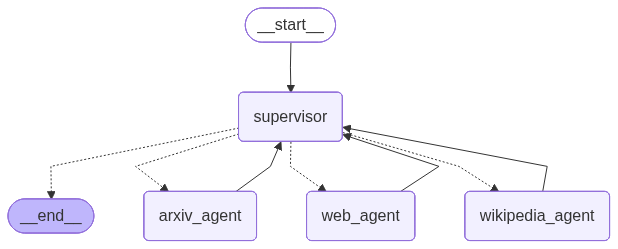

In [37]:
from langgraph.prebuilt.chat_agent_executor import AgentState
AgentState.__annotations__.keys()

from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [ ]:
query = "Deep research plan: Find SOTA RAG papers (2024–2025), collect canonical citations and key claims; add solid Wikipedia/overview links."
# query = plan_res.steps[0].task


init_state = {
    "messages": [{"role": "user", "content": query}],
    "facts": [],           # seed your reducer fields
    "blackboard": [],
    "done": False
}

last_parent_state = None

for ns, state in supervisor.stream(
    init_state,
    config={"recursion_limit": 15},
    stream_mode="values",          # full state
    subgraphs=True,                # include parent + child snapshots
):
    # ns is a tuple path like ("supervisor:<id>",) or ("supervisor:<id>", "web_agent:<id>")
    # print("STATE FROM:", " > ".join(ns))
    print("FIELDS:", list(state.keys()))
    print("BLACKBOARD SIZE:", len(state.get("facts", [])))
    # print messages for that graph (parent or child)
    for m in state.get("messages", []):
        m.pretty_print()
    # keep last parent snapshot to read facts later
    if len(ns) == 1 and ns[0].startswith("supervisor:"):
        last_parent_state = state

facts = (last_parent_state or state).get("facts", [])

FIELDS: ['messages']
BLACKBOARD SIZE: 0
================================ Human Message =================================

Deep research plan: Find SOTA RAG papers (2024–2025), collect canonical citations and key claims; add solid Wikipedia/overview links.
FIELDS: ['messages']
BLACKBOARD SIZE: 0
================================ Human Message =================================

Deep research plan: Find SOTA RAG papers (2024–2025), collect canonical citations and key claims; add solid Wikipedia/overview links.
FIELDS: ['messages']
BLACKBOARD SIZE: 0
================================ Human Message =================================

Deep research plan: Find SOTA RAG papers (2024–2025), collect canonical citations and key claims; add solid Wikipedia/overview links.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_web_agent (call_gMGtoV8KzGJhOIKOGDy8mQJI)
 Call ID: call_gMGtoV8KzGJhOIKOGDy8mQJI
  Args:
FIELDS: ['messages

ValueError: Expected to have a matching ToolMessage in Command.update for tool 'add_general_reference_tool', got: []. Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage. You can fix it by modifying the tool to return `Command(update=[ToolMessage("Success", tool_call_id=tool_call_id), ...], ...)`.

In [33]:
event.keys()


dict_keys(['messages'])

In [ ]:
from langgraph.prebuilt import create_react_agent

# system_prompt = (
#     "You are a specialized research assistant. "
#     "For any given question, use the available tools to find the most relevant and up-to-date information. "
#     "Think step-by-step about which tool is best for the task."
#     "Additional Rules:"
#     "- Do NOT produce a narrative final answer."
#     "- When COMPLETELY DONE, you MUST call the tool `submit_research` EXACTLY ONCE with a payload matching the ResearchOutput schema (topic, facts[])."
#     "- After calling `submit_research`, STOP. Do not say anything else."
# )

system_prompt = (
    "You are a specialized research assistant. Your goal is to build a knowledge base of facts about the research topic."
    "Think step-by-step. First, search for information using the available tools."
    "When you find a relevant source, extract the information and add it to the blackboard using the appropriate tool:"
    "- For a peer-reviewed paper or arXiv preprint, use `add_scholar_reference`."
    "- For a blog post, documentation, or tutorial, use `add_general_reference`."
    "- For synthesizing an insight from multiple sources you've already added, use `add_finding`." # A potential future tool
    
    "Continue this process of searching and adding facts until you have a comprehensive overview of the topic."
    "When you believe you have gathered enough information and have no more steps, use the `finish_research` tool to end the process."
)

research_llm = ChatOpenAI(model="gpt-5-nano",temperature=0) #for react agent must have "free" llm, no structured output

researcher_agent = create_react_agent(
    model= research_llm,
    tools = tools, #research_tools,
    prompt=system_prompt,
)


##### TOY GRAPH

In [ ]:
def planner_node(state: ResearchState):
    """
    Takes the topic and generates a research plan.
    """
    print("--- 🧠 Planning ---")
    # This is the planner chain you created earlier
    plan = planner_chain.invoke({"topic": state["topic"]}) 
    return {"plan": plan}


def researcher_node(state: ResearchState):
    """
    This node runs the researcher agent for a single step of the plan.
    It inspects the agent's tool calls and collects any facts that were added.
    """
    print("--- 📚 Researching ---")
    
    # Determine which step of the plan to execute
    current_step_index = len(state['facts'])
    plan = state["plan"]
    
    if current_step_index >= len(plan.steps):
        return {}

    current_step = plan.steps[current_step_index]
    print(f"--- Running Step {current_step_index + 1}: {current_step.task} ---")
    
    # Run the agent executor
    result = research_agent_executor.invoke({"input": current_step.task})
    
    # Collect all facts that were added during this run
    new_facts_from_this_run = []
    for step in result.get('intermediate_steps', []):
        action, observation = step
        # Check if the tool called was our 'add_fact' tool
        if action.tool == "add_fact":
            # The 'observation' is the return value of the tool, which is our Fact object
            new_facts_from_this_run.append(observation)
            
    # Return the list of newly added facts to be appended to the state
    return {"facts": new_facts_from_this_run}


In [ ]:

# This dictionary IS your blackboard for now.
research_state = {
    "topic": "Latest techniques in LLM quantization",
    "facts": [], # Starts empty
}

# researcher_out = researcher_agent.invoke({"messages": [("user", plan_res.steps[0].task)]})
for event in researcher_agent.stream({"messages": [("user", plan_res.steps[0].task)]}):
    update = event.get("agent", event.get("tools", {}))
    for msg in update.get("messages", []):
        msg.pretty_print()        # nice formatting of AI/Human/Tool messages


================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_yJNxMDSgzIheE7g7XxhfmOWl)
 Call ID: call_yJNxMDSgzIheE7g7XxhfmOWl
  Args:
    query: "Retrieval-Augmented Generation" survey 2024
  arxiv_search (call_O7hSkUlfMF8vcFS2FkJWPJBo)
 Call ID: call_O7hSkUlfMF8vcFS2FkJWPJBo
  Args:
    query: Self-RAG: Learning to Retrieve, Generate, and Critique 2023
  arxiv_search (call_UWe9HJJUGqosW2ewvg3b3GKD)
 Call ID: call_UWe9HJJUGqosW2ewvg3b3GKD
  Args:
    query: Corrective Retrieval Augmented Generation 2023
  arxiv_search (call_lXOtwCN1zELMOIWYmXbngGDY)
 Call ID: call_lXOtwCN1zELMOIWYmXbngGDY
  Args:
    query: RAPTOR retrieval augmented generation 2024
  arxiv_search (call_P1sFJigOgPD2qI5jEqliqrAD)
 Call ID: call_P1sFJigOgPD2qI5jEqliqrAD
  Args:
    query: GraphRAG 2024 arXiv
  arxiv_search (call_mAF28J9hkQP0BnuLi6mbn0N7)
 Call ID: call_mAF28J9hkQP0BnuLi6mbn0N7
  Args:
    query: RA-DIT retrieval-augmented dual instruction tuning 2024


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-5 in organization org-CvhbXKiCglUO2AailKiueQpr on tokens per min (TPM): Limit 30000, Requested 41616. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [7]:
researcher_agent.aget_state

<bound method Pregel.aget_state of <langgraph.graph.state.CompiledStateGraph object at 0x7f03fc0d2e90>>

In [ ]:
try:
    data = json.loads(msg.content)          # you returned model_dump_json()
    print("\n📦 submit_research payload (pretty):\n")
    print(json.dumps(data, indent=2, ensure_ascii=False))
except json.JSONDecodeError:
    # Fallback if something odd happens
    print("\n⚠️ Could not parse submit_research JSON; raw content:\n")
    print(msg.content)


📦 submit_research payload (pretty):

{
  "topic": "RAG (Retrieval-Augmented Generation): 2023–2025 sources (papers, blogs, library releases, talks)",
  "facts": [
    {
      "id": null,
      "kind": "scholar_reference",
      "created_at": "2025-09-03T13:15:10.557529Z",
      "scholar_references": null,
      "general_references": null,
      "confidence": null
    },
    {
      "id": null,
      "kind": "scholar_reference",
      "created_at": "2025-09-03T13:15:10.557550Z",
      "scholar_references": null,
      "general_references": null,
      "confidence": null
    },
    {
      "id": null,
      "kind": "scholar_reference",
      "created_at": "2025-09-03T13:15:10.557554Z",
      "scholar_references": null,
      "general_references": null,
      "confidence": null
    },
    {
      "id": null,
      "kind": "scholar_reference",
      "created_at": "2025-09-03T13:15:10.557558Z",
      "scholar_references": null,
      "general_references": null,
      "confidence": null
   

#### How to inspect outputs of react

In [ ]:
result = researcher_agent.invoke({"messages": [("user", "Latest on multimodal RAG?")]})
print(result["messages"][-1].content)

In [ ]:
for event in researcher_agent.stream({"messages": [("user", "Latest on multimodal RAG?")]}):
    # Each event is a *delta* keyed by node name, e.g. "agent" or "tools"
    update = event.get("agent", event.get("tools", {}))
    for msg in update.get("messages", []):
        msg.pretty_print()        # nice formatting of AI/Human/Tool messages


In [ ]:
from langchain_core.messages import HumanMessage

print("--- Testing agent's tool choice ---")
# Invoke the agent with a sample message
response = researcher_agent.invoke({"messages": [HumanMessage(content="What is the latest on multimodal RAG?")]})

# The response AIMessage should contain tool_calls

--- Testing agent's tool choice ---


AttributeError: 'dict' object has no attribute 'tool_calls'

In [35]:
for msg in response["messages"]:
    msg.pretty_print()
# print(response["messages"])


================================ Human Message =================================

What is the latest on multimodal RAG?
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_i8nSHa1CNgOUqypeBL3XWbHw)
 Call ID: call_i8nSHa1CNgOUqypeBL3XWbHw
  Args:
    query: multimodal RAG
  arxiv_search (call_LvxxsYffKBGiym2o0voJFkvi)
 Call ID: call_LvxxsYffKBGiym2o0voJFkvi
  Args:
    query: multimodal retrieval-augmented generation
  arxiv_search (call_Rx7GNzde8MeCRYzSJPfl6TD5)
 Call ID: call_Rx7GNzde8MeCRYzSJPfl6TD5
  Args:
    query: RAG images multimodal
  arxiv_search (call_xRz8DTj9CKS55VZuzQCYJTTC)
 Call ID: call_xRz8DTj9CKS55VZuzQCYJTTC
  Args:
    query: MMRAG multimodal
  tavily_search_results_json (call_7JUKbygl4N5JzATPmDVEkxdZ)
 Call ID: call_7JUKbygl4N5JzATPmDVEkxdZ
  Args:
    query: multimodal retrieval augmented generation latest
  tavily_search_results_json (call_5HoiDs0C4lHfwXOMDnESaaIR)
 Call ID: call_5HoiDs0C4lHfwXOMDnESaa

### Create Graph 